In [9]:
#Importing libraries

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [10]:
data_path = '/Users/aleksandrastojanovic/Desktop/data_science_projects/COVID-19_Radiography_Dataset'
categories = ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']

#This code is used to verify the structure of dataset. 

#Initializing lists
category_list = []
images_list = []
masks_list = []

#Iterating over categories
for category in categories:
    image_dir = os.path.join(data_path, category, 'images')
    mask_dir = os.path.join(data_path, category, 'masks')
    num_images = len(os.listdir(image_dir)) #Counts the number of the files in images folders
    num_masks = len(os.listdir(mask_dir)) #Couts the number of the files in masks folders
    category_list.append(category)
    images_list.append(num_images)
    masks_list.append(num_masks)

data = {'Category': category_list, 'Images': images_list, 'Masks': masks_list} #Creating a new data frame, dictionary.
df = pd.DataFrame(data)

title = 'Number of Images and Masks for each Category'
print(title)
df.head()

Number of Images and Masks for each Category


,Category,Images,Masks
0,Normal,10192,10192
1,Lung_Opacity,6012,6012
2,Viral Pneumonia,1345,1345
3,COVID,3616,3616


In [11]:
import joblib

file_path = '/Users/aleksandrastojanovic/Desktop/data_science_projects/COVID-19_Radiography_Dataset/data_lungs_raw.joblib'
loaded_object = joblib.load(file_path)

print(type(loaded_object))

<class 'pandas.core.frame.DataFrame'>


In [2]:
print(loaded_object.head())

   0  1  2  3  4  5  6  7  8  9  ...  65527  65528  65529  65530  65531  \
0  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
1  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
2  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
3  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
4  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   

   65532  65533  65534  65535   label  
0      0      0      0      0  Normal  
1      0      0      0      0  Normal  
2      0      0      0      0  Normal  
3      0      0      0      0  Normal  
4      0      0      0      0  Normal  

[5 rows x 65537 columns]


In [12]:
print(loaded_object.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Columns: 65537 entries, 0 to label
dtypes: object(1), uint8(65536)
memory usage: 1.3+ GB
None


In [13]:
import joblib
from sklearn.model_selection import train_test_split

file_path = '/Users/aleksandrastojanovic/Desktop/data_science_projects/COVID-19_Radiography_Dataset/data_lungs_raw.joblib'
loaded_data = joblib.load(file_path)

X = loaded_data.drop(columns=['label']) 
y = loaded_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [14]:
import numpy as np
import pickle
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

class_weights_path = 'class_weights.pkl'
with open(class_weights_path, 'wb') as f:
    pickle.dump(class_weights_dict, f)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)

rf_classifier.fit(X_train_scaled, y_train)

y_pred = rf_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

import pickle

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights_dict, f)

with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)


Accuracy: 0.7543


In [17]:
from sklearn.metrics import classification_report

y_pred = rf_classifier.predict(X_test_scaled)

report = classification_report(y_test, y_pred, target_names=categories)
print("Classification Report:\n", report)


Classification Report:
                  precision    recall  f1-score   support

         Normal       0.75      0.37      0.49       726
   Lung_Opacity       0.76      0.75      0.75      1236
Viral Pneumonia       0.74      0.92      0.82      1995
          COVID       0.93      0.62      0.75       276

       accuracy                           0.75      4233
      macro avg       0.80      0.66      0.70      4233
   weighted avg       0.76      0.75      0.74      4233



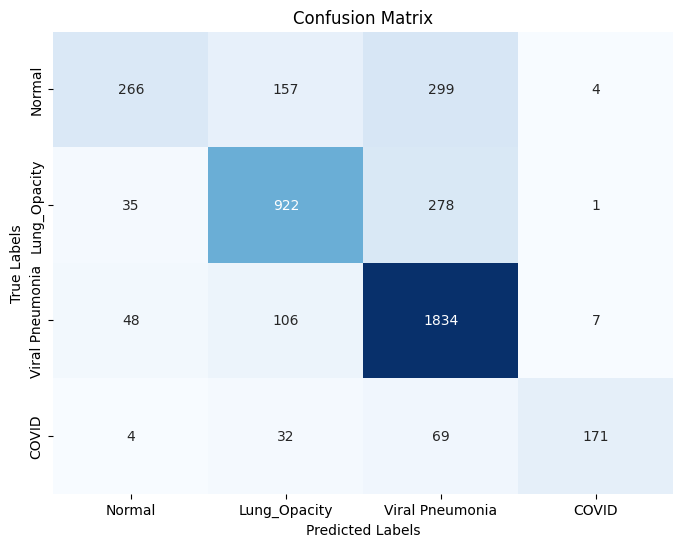

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
import pickle

with open('random_forest_model.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)

with open('standard_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('class_weights.pkl', 'rb') as f:
    class_weights_dict = pickle.load(f)

with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)


In [20]:
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the Bagging classifier
bagging_classifier = BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=100, random_state=123)
bagging_classifier.fit(X_train_scaled, y_train)

with open('bagging_classifier.pkl', 'wb') as f:
    pickle.dump(bagging_classifier, f)

with open('class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f)

with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [21]:
# Load the Bagging classifier
with open('bagging_classifier.pkl', 'rb') as f:
    bagging_classifier = pickle.load(f)

# Load the class weights
with open('class_weights.pkl', 'rb') as f:
    class_weights = pickle.load(f)

# Load the categories
with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Evaluate the Bagging classifier
y_pred = bagging_classifier.predict(X_test_scaled)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=categories)
print("Classification Report:\n", report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Classification Report:
                  precision    recall  f1-score   support

         Normal       0.78      0.29      0.42       726
   Lung_Opacity       0.74      0.74      0.74      1236
Viral Pneumonia       0.72      0.93      0.81      1995
          COVID       0.95      0.57      0.71       276

       accuracy                           0.74      4233
      macro avg       0.80      0.63      0.67      4233
   weighted avg       0.75      0.74      0.72      4233

Confusion Matrix:
 [[ 208  180  335    3]
 [  29  918  288    1]
 [  27  113 1850    5]
 [   2   28   89  157]]


In [22]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7401370186628868


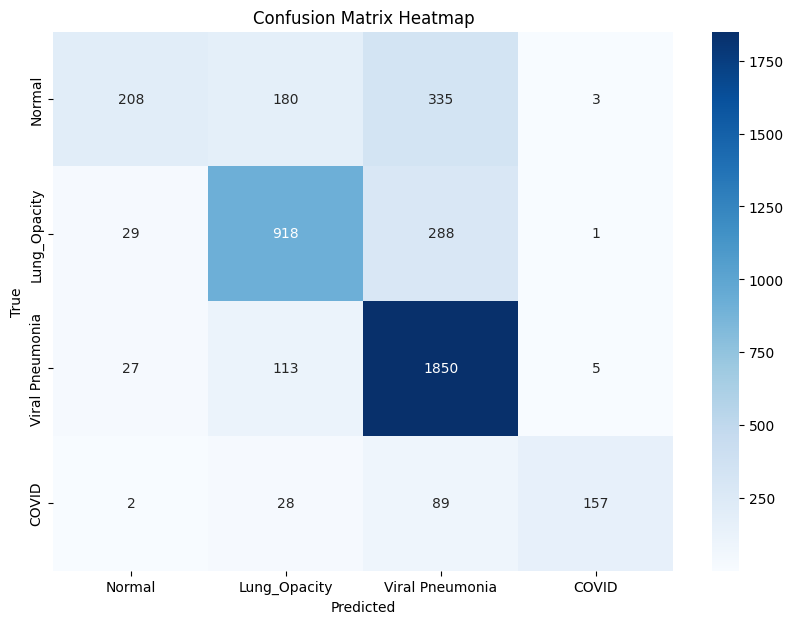

In [23]:
# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [25]:
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=4, scale_pos_weight=class_weights)
xgb_classifier.fit(X_train_scaled, y_train_encoded)

# Save the XGBoost classifier
xgb_classifier.save_model('xgb_classifier.json')

# Save the class weights
with open('class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f)

# Save the categories
with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [08:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
                  precision    recall  f1-score   support

         Normal       0.74      0.48      0.58       726
   Lung_Opacity       0.77      0.77      0.77      1236
Viral Pneumonia       0.79      0.91      0.85      1995
          COVID       0.94      0.80      0.87       276

       accuracy                           0.79      4233
      macro avg       0.81      0.74      0.77      4233
   weighted avg       0.79      0.79      0.78      4233

Confusion Matrix:
 [[ 346  157  222    1]
 [  57  946  232    1]
 [  57  102 1825   11]
 [   5   19   31  221]]
Accuracy: 0.788566028821167


<function matplotlib.pyplot.title(label: 'str', fontdict: 'dict[str, Any] | None' = None, loc: "Literal['left', 'center', 'right'] | None" = None, pad: 'float | None' = None, *, y: 'float | None' = None, **kwargs) -> 'Text'>

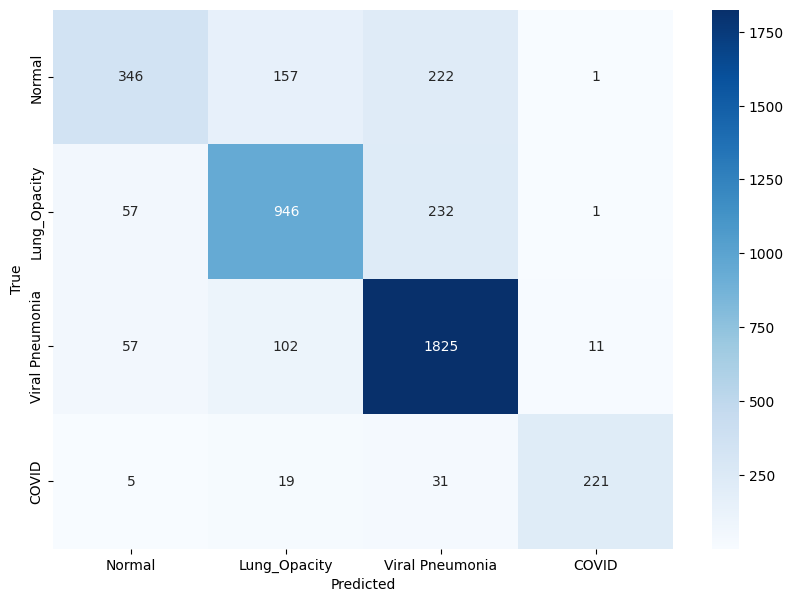

In [26]:
# Load the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.load_model('xgb_classifier.json')

# Load the class weights
with open('class_weights.pkl', 'rb') as f:
    class_weights = pickle.load(f)

# Load the categories
with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load the label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Evaluate the XGBoost classifier
y_pred_encoded = xgb_classifier.predict(X_test_scaled)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=categories)
print("Classification Report:\n", report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title

In [28]:
import joblib

file_path_2 = '/Users/aleksandrastojanovic/Desktop/data_science_projects/COVID-19_Radiography_Dataset/data_lungs_filtered.joblib'
loaded_object_2 = joblib.load(file_path_2)

print(type(loaded_object_2))

<class 'pandas.core.frame.DataFrame'>


In [29]:
print(loaded_object_2.head())

   0  1  2  3  4  5  6  7  8  9  ...  65527  65528  65529  65530  65531  \
0  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
1  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
2  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
3  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
4  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   

   65532  65533  65534  65535   label  
0      0      0      0      0  Normal  
1      0      0      0      0  Normal  
2      0      0      0      0  Normal  
3      0      0      0      0  Normal  
4      0      0      0      0  Normal  

[5 rows x 65537 columns]


In [32]:
import joblib
from sklearn.model_selection import train_test_split

file_path_2 = '/Users/aleksandrastojanovic/Desktop/data_science_projects/COVID-19_Radiography_Dataset/data_lungs_filtered.joblib'
loaded_data_2 = joblib.load(file_path_2)

X_filtered = loaded_data_2.drop(columns=['label'])  
y_filtered = loaded_data_2['label']

X_filtered_train, X_filtered_test, y_filtered_train, y_filtered_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=123)


In [33]:
import numpy as np
import pickle
from sklearn.utils import class_weight

# Example: Compute class weights
class_weights_filtered = class_weight.compute_class_weight('balanced', classes=np.unique(y_filtered_train), y=y_filtered_train)
class_weights_filtered_dict = dict(enumerate(class_weights_filtered))

# Save class weights using pickle
class_weights_filtered_path = 'class_weights_filtered.pkl'
with open(class_weights_filtered_path, 'wb') as f:
    pickle.dump(class_weights_dict, f)


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_filtered_train_scaled = scaler.fit_transform(X_filtered_train)
X_filtered_test_scaled = scaler.transform(X_filtered_test)


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier_filtered = RandomForestClassifier(n_estimators=100, random_state=123)

rf_classifier_filtered.fit(X_filtered_train_scaled, y_filtered_train)

y_filtered_pred = rf_classifier_filtered.predict(X_filtered_test_scaled)

accuracy = accuracy_score(y_filtered_test, y_filtered_pred)
print(f'Accuracy: {accuracy:.4f}')

import pickle

with open('random_forest_model_filtered.pkl', 'wb') as f:
    pickle.dump(rf_classifier_filtered, f)

with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('class_weights_filtered.pkl', 'wb') as f:
    pickle.dump(class_weights_filtered_dict, f)

with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

Accuracy: 0.5615


In [36]:
import pickle

with open('random_forest_model_filtered.pkl', 'rb') as f:
    rf_classifier_filtered = pickle.load(f)

with open('standard_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('class_weights_filtered.pkl', 'rb') as f:
    class_weights_filtered_dict = pickle.load(f)

with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)


In [37]:
from sklearn.metrics import classification_report

y_filtered_pred = rf_classifier_filtered.predict(X_filtered_test_scaled)

report2 = classification_report(y_filtered_test, y_filtered_pred, target_names=categories)
print("Classification Report:\n", report)


Classification Report:
                  precision    recall  f1-score   support

         Normal       0.74      0.48      0.58       726
   Lung_Opacity       0.77      0.77      0.77      1236
Viral Pneumonia       0.79      0.91      0.85      1995
          COVID       0.94      0.80      0.87       276

       accuracy                           0.79      4233
      macro avg       0.81      0.74      0.77      4233
   weighted avg       0.79      0.79      0.78      4233



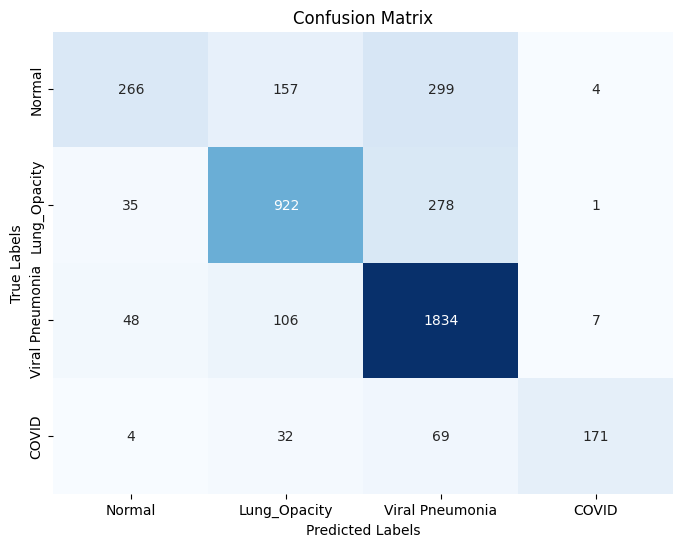

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm2 = confusion_matrix(y_filtered_test, y_filtered_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [39]:
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the Bagging classifier
bagging_classifier_filtered = BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=100, random_state=123)
bagging_classifier_filtered.fit(X_filtered_train_scaled, y_filtered_train)

with open('bagging_classifier_filtered.pkl', 'wb') as f:
    pickle.dump(bagging_classifier_filtered, f)

with open('class_weights_filtered.pkl', 'wb') as f:
    pickle.dump(class_weights_filtered, f)

with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [40]:
# Load the Bagging classifier
with open('bagging_classifier_filtered.pkl', 'rb') as f:
    bagging_classifier_filtered = pickle.load(f)

# Load the class weights
with open('class_weights_filtered.pkl', 'rb') as f:
    class_weights_filtered = pickle.load(f)

# Load the categories
with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Evaluate the Bagging classifier
y_filtered_pred = bagging_classifier_filtered.predict(X_filtered_test_scaled)

# Generate the classification report
report2 = classification_report(y_filtered_test, y_filtered_pred, target_names=categories)
print("Classification Report:\n", report2)

# Generate the confusion matrix
conf_matrix2 = confusion_matrix(y_filtered_test, y_filtered_pred)
print("Confusion Matrix:\n", conf_matrix2)

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.95      0.03      0.05       726
   Lung_Opacity       0.62      0.35      0.44      1236
Viral Pneumonia       0.53      0.94      0.68      1995
          COVID       1.00      0.01      0.02       276

       accuracy                           0.55      4233
      macro avg       0.78      0.33      0.30      4233
   weighted avg       0.66      0.55      0.46      4233

Confusion Matrix:
 [[  20  132  574    0]
 [   1  427  808    0]
 [   0  119 1876    0]
 [   0   12  261    3]]


In [41]:
accuracy2 = accuracy_score(y_filtered_test, y_filtered_pred)
print("Accuracy:", accuracy2)

Accuracy: 0.549492085991023


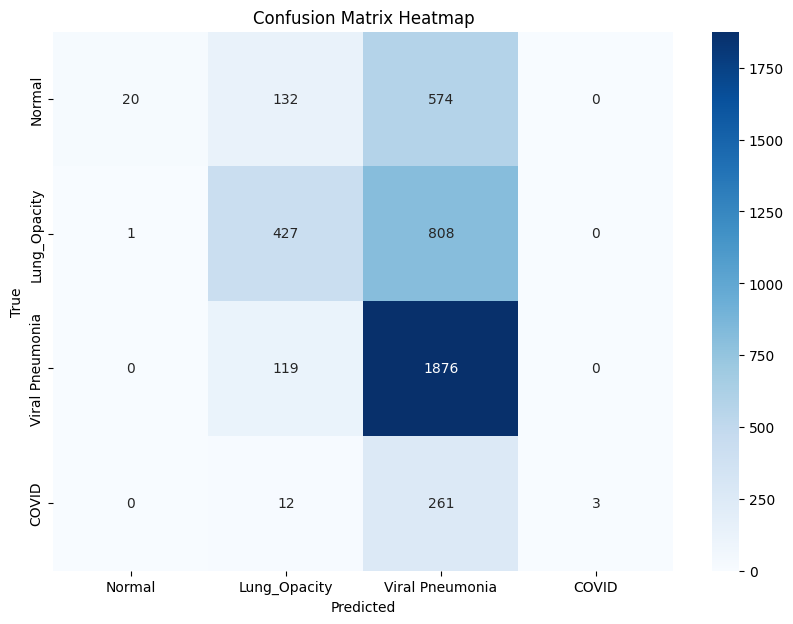

In [42]:
# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [44]:
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Encode the labels
label_encoder = LabelEncoder()
y_filtered_train_encoded = label_encoder.fit_transform(y_filtered_train)
y_filtered_test_encoded = label_encoder.transform(y_filtered_test)

# Train the XGBoost classifier
xgb_classifier_filtered = xgb.XGBClassifier(objective='multi:softmax', num_class=4, scale_pos_weight=class_weights_filtered)
xgb_classifier_filtered.fit(X_filtered_train_scaled, y_filtered_train_encoded)

# Save the XGBoost classifier
xgb_classifier_filtered.save_model('xgb_classifier_filtered.json')

# Save the class weights
with open('class_weights_filtered.pkl', 'wb') as f:
    pickle.dump(class_weights_filtered, f)

# Save the categories
with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the label encoder
with open('label_encoder_filtered.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:14:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [46]:
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the XGBoost classifier
xgb_classifier_filtered = xgb.XGBClassifier()
xgb_classifier_filtered.load_model('xgb_classifier_filtered.json')

# Load the class weights
with open('class_weights_filtered.pkl', 'rb') as f:
    class_weights_filtered = pickle.load(f)

# Load the categories
with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load the label encoder
with open('label_encoder_filtered.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Encode the true labels
y_filtered_test_encoded = label_encoder.transform(y_filtered_test)

# Evaluate the XGBoost classifier
y_filtered_pred_encoded = xgb_classifier_filtered.predict(X_filtered_test_scaled)

# Generate the classification report
report2 = classification_report(y_filtered_test_encoded, y_filtered_pred_encoded, target_names=categories)
print("Classification Report:\n", report2)

# Generate the confusion matrix
conf_matrix2 = confusion_matrix(y_filtered_test_encoded, y_filtered_pred_encoded)
print("Confusion Matrix:\n", conf_matrix2)

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.50      0.16      0.24       726
   Lung_Opacity       0.58      0.56      0.57      1236
Viral Pneumonia       0.64      0.85      0.73      1995
          COVID       0.85      0.51      0.64       276

       accuracy                           0.62      4233
      macro avg       0.64      0.52      0.54      4233
   weighted avg       0.61      0.62      0.59      4233

Confusion Matrix:
 [[ 113  230  379    4]
 [  64  693  478    1]
 [  47  238 1690   20]
 [   3   24  108  141]]


In [47]:
# Calculate the accuracy
accuracy2 = accuracy_score(y_filtered_test_encoded, y_filtered_pred_encoded)
print("Accuracy:", accuracy2)

Accuracy: 0.622962437987243


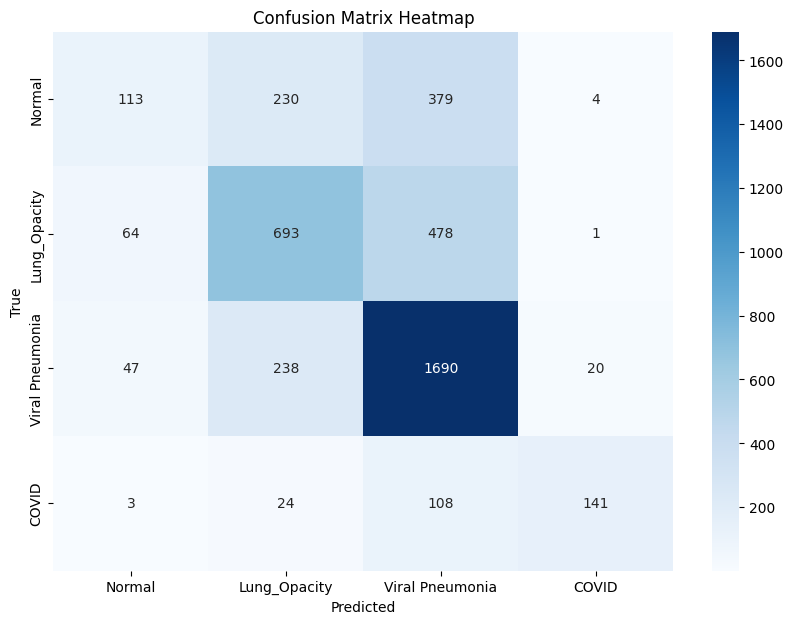

In [48]:
# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [58]:
results = {
    'Model': ['Random Forest', 'Bagging', 'XGBoost'],
    'Accuracy': [0.75, 0.74, 0.79],
    'Precision_Normal': [0.75, 0.78, 0.74],
    'Recall_Normal': [0.37, 0.29, 0.48],
    'F1-Score_Normal': [0.49, 0.42, 0.58],
    'Precision_Lung_Opacity': [0.76, 0.74, 0.77],
    'Recall_Lung_Opacity': [0.75, 0.74, 0.77],
    'F1-Score_Lung_Opacity': [0.75, 0.74, 0.77],
    'Precision_Viral_Pneumonia': [0.74, 0.72, 0.79],
    'Recall_Viral_Pneumonia': [0.92, 0.93, 0.91],
    'F1-Score_Viral_Pneumonia': [0.82, 0.81, 0.85],
    'Precision_COVID': [0.93, 0.95, 0.94],
    'Recall_COVID': [0.62, 0.57, 0.80],
    'F1-Score_COVID': [0.75, 0.71, 0.87]
}

summary_classification_df = pd.DataFrame(results)
summary_classification_df.head()


,Model,Accuracy,Precision_Normal,Recall_Normal,F1-Score_Normal,Precision_Lung_Opacity,Recall_Lung_Opacity,F1-Score_Lung_Opacity,Precision_Viral_Pneumonia,Recall_Viral_Pneumonia,F1-Score_Viral_Pneumonia,Precision_COVID,Recall_COVID,F1-Score_COVID
0,Random Forest,0.75,0.75,0.37,0.49,0.76,0.75,0.75,0.74,0.92,0.82,0.93,0.62,0.75
1,Bagging,0.74,0.78,0.29,0.42,0.74,0.74,0.74,0.72,0.93,0.81,0.95,0.57,0.71
2,XGBoost,0.79,0.74,0.48,0.58,0.77,0.77,0.77,0.79,0.91,0.85,0.94,0.80,0.87


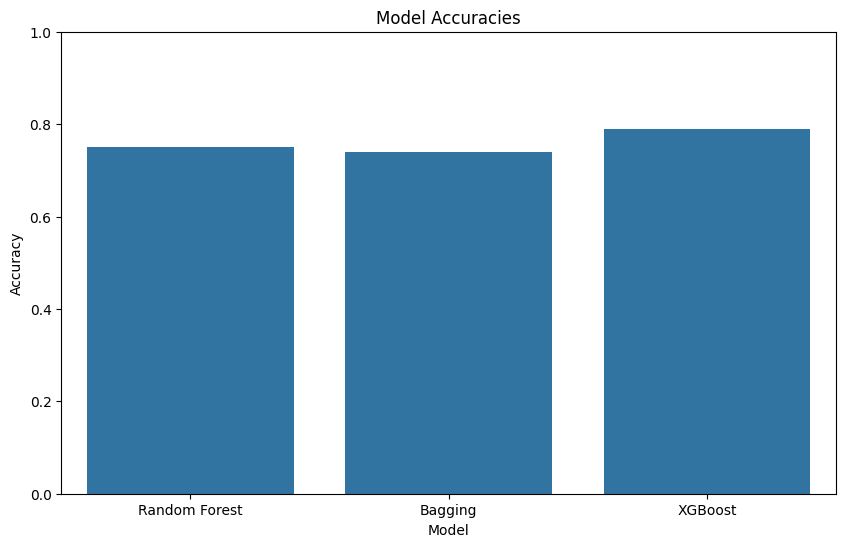

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=summary_classification_df)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()


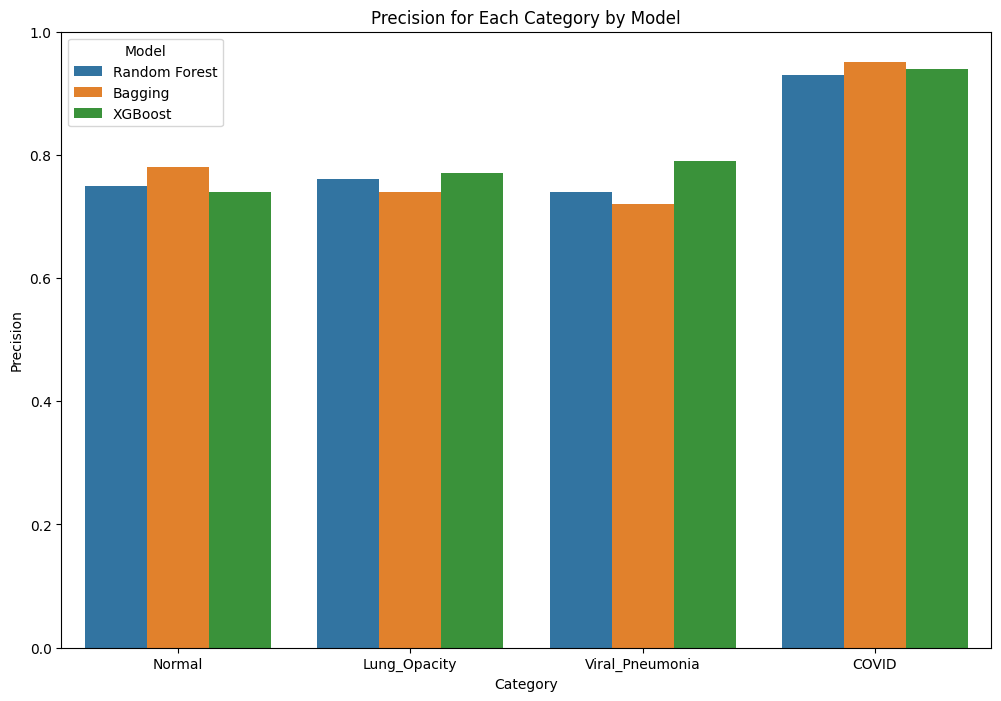

In [63]:
# Melting the DataFrame for precision values
precision_df = summary_classification_df.melt(id_vars=['Model'], 
                                              value_vars=[f'Precision_{category}' for category in categories],
                                              var_name='Category', value_name='Precision')


precision_df['Category'] = precision_df['Category'].str.replace('Precision_', '')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Category', y='Precision', hue='Model', data=precision_df)
plt.title('Precision for Each Category by Model')
plt.ylabel('Precision')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()

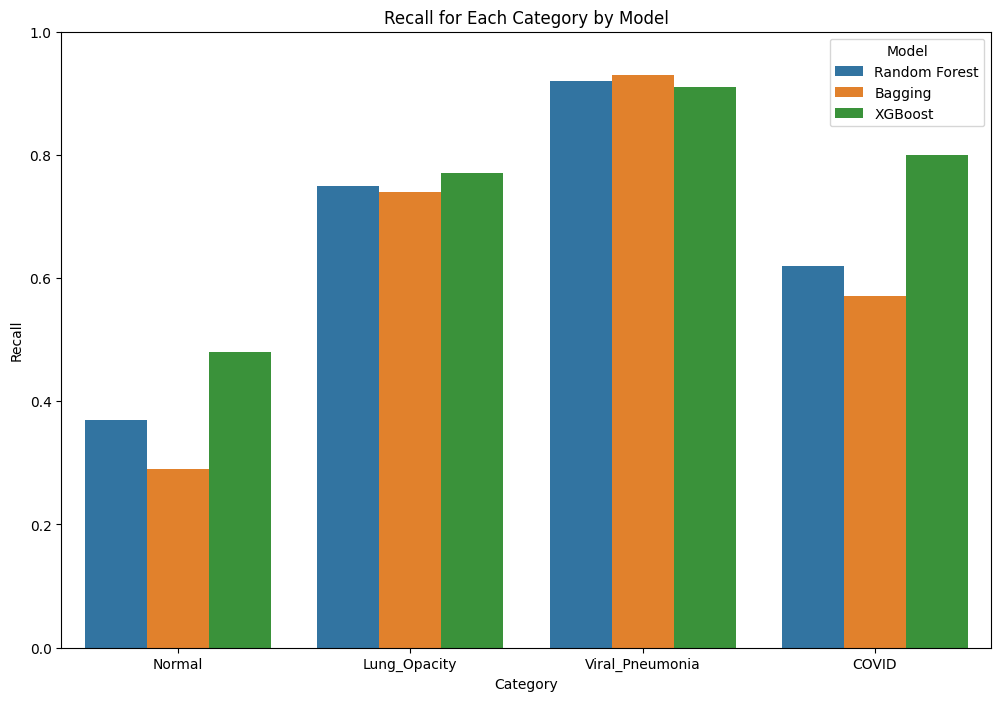

In [64]:
recall_df = summary_classification_df.melt(id_vars=['Model'], 
                                           value_vars=[f'Recall_{category}' for category in categories],
                                           var_name='Metric', value_name='Value')


recall_df['Metric'] = recall_df['Metric'].str.replace('Recall_', '')

# Plotting Recall
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=recall_df)
plt.title('Recall for Each Category by Model')
plt.ylabel('Recall')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()



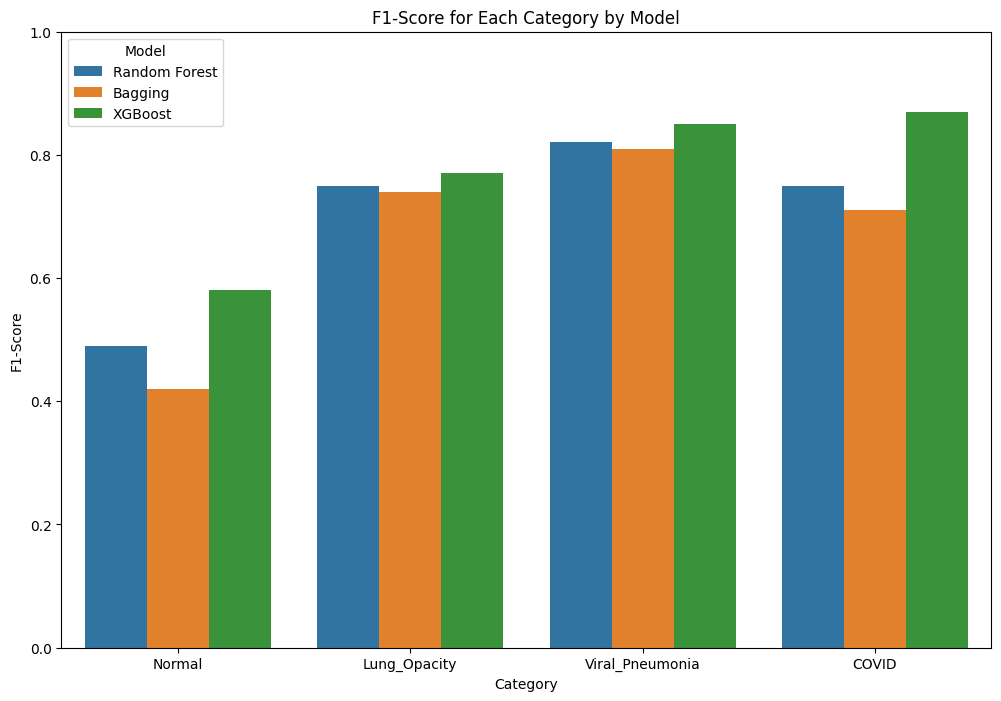

In [65]:
f1_score_df = summary_classification_df.melt(id_vars=['Model'], 
                                             value_vars=[f'F1-Score_{category}' for category in categories],
                                             var_name='Metric', value_name='Value')

# Removing the 'F1-Score_' prefix
f1_score_df['Metric'] = f1_score_df['Metric'].str.replace('F1-Score_', '')

# Plotting F1-Score
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=f1_score_df)
plt.title('F1-Score for Each Category by Model')
plt.ylabel('F1-Score')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()


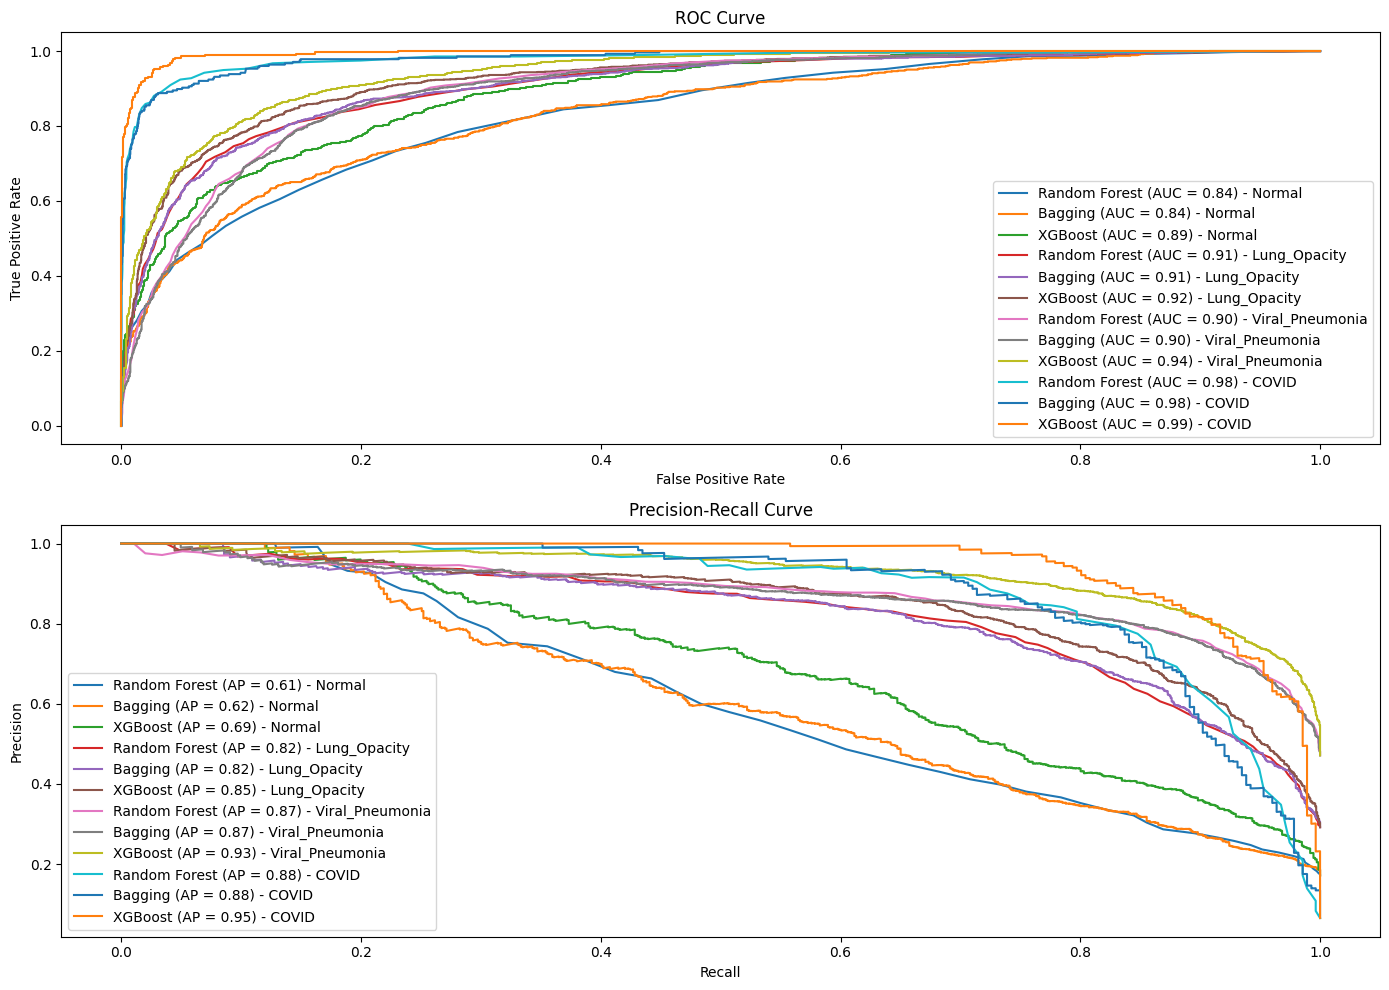

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Get predicted probabilities
rf_y_prob = rf_classifier.predict_proba(X_test_scaled)
bagging_y_prob = bagging_classifier.predict_proba(X_test_scaled)
xgb_y_prob = xgb_classifier.predict_proba(X_test_scaled)

# Initialize plots for ROC and PR curves
plt.figure(figsize=(14, 10))

# Calculate ROC and PR curves for each class
for i, category in enumerate(categories):
    # Random Forest
    rf_fpr, rf_tpr, _ = roc_curve(y_test_encoded == i, rf_y_prob[:, i])
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    rf_precision, rf_recall, _ = precision_recall_curve(y_test_encoded == i, rf_y_prob[:, i])
    rf_average_precision = average_precision_score(y_test_encoded == i, rf_y_prob[:, i])

    # Bagging Classifier
    bagging_fpr, bagging_tpr, _ = roc_curve(y_test_encoded == i, bagging_y_prob[:, i])
    bagging_roc_auc = auc(bagging_fpr, bagging_tpr)
    bagging_precision, bagging_recall, _ = precision_recall_curve(y_test_encoded == i, bagging_y_prob[:, i])
    bagging_average_precision = average_precision_score(y_test_encoded == i, bagging_y_prob[:, i])

    # XGBoost
    xgb_fpr, xgb_tpr, _ = roc_curve(y_test_encoded == i, xgb_y_prob[:, i])
    xgb_roc_auc = auc(xgb_fpr, xgb_tpr)
    xgb_precision, xgb_recall, _ = precision_recall_curve(y_test_encoded == i, xgb_y_prob[:, i])
    xgb_average_precision = average_precision_score(y_test_encoded == i, xgb_y_prob[:, i])

    # Plot ROC curve
    plt.subplot(2, 1, 1)
    plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f}) - {category}')
    plt.plot(bagging_fpr, bagging_tpr, label=f'Bagging (AUC = {bagging_roc_auc:.2f}) - {category}')
    plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.2f}) - {category}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')

    # Plot PR curve
    plt.subplot(2, 1, 2)
    plt.plot(rf_recall, rf_precision, label=f'Random Forest (AP = {rf_average_precision:.2f}) - {category}')
    plt.plot(bagging_recall, bagging_precision, label=f'Bagging (AP = {bagging_average_precision:.2f}) - {category}')
    plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AP = {xgb_average_precision:.2f}) - {category}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()


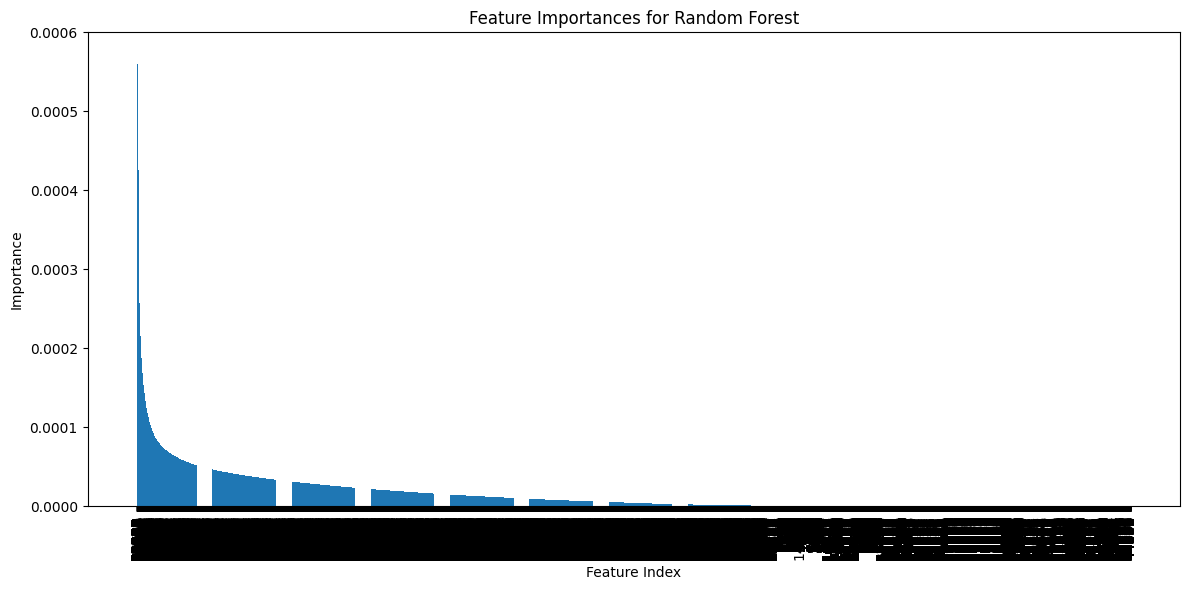

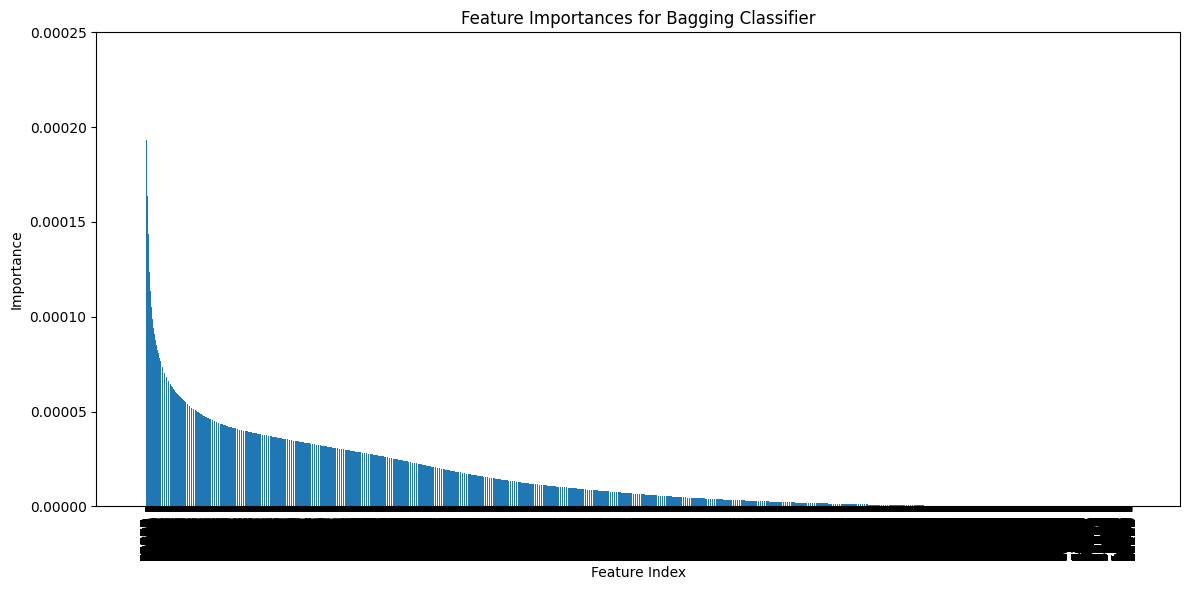

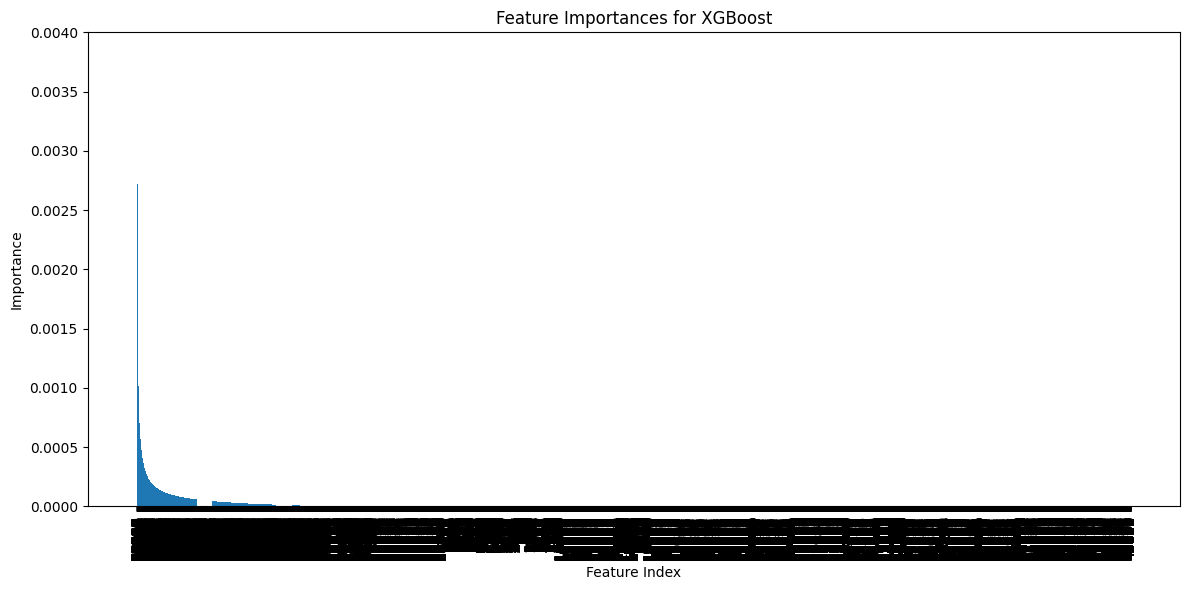

In [53]:
# Plot feature importances for Random Forest and Bagging Classifier
for model_name, model in models.items():
    if model_name == 'Random Forest':
        importances = model.feature_importances_
        ylim = (0, 0.0006)
    elif model_name == 'Bagging Classifier':
        importances = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)
        ylim = (0, 0.00025)
    else:
        continue

    indices = np.argsort(importances)[::-1]
    features = X.columns

    plt.figure(figsize=(12, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), features[indices], rotation=90)
    plt.ylim(*ylim)
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

# Plot feature importances for XGBoost
xgb_importances = xgb_classifier.feature_importances_
indices = np.argsort(xgb_importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
plt.title('Feature Importances for XGBoost')
plt.bar(range(X.shape[1]), xgb_importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.ylim(0, 0.004)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()



In [66]:
results_filtered = {
    'Model': ['Random Forest', 'Bagging', 'XGBoost'],
    'Accuracy': [0.56, 0.55, 0.62],
    'Precision_Normal': [0.74, 0.95, 0.50],
    'Recall_Normal': [0.48, 0.03, 0.16],
    'F1-Score_Normal': [0.58, 0.05, 0.24],
    'Precision_Lung_Opacity': [0.77, 0.62, 0.58],
    'Recall_Lung_Opacity': [0.77, 0.35, 0.56],
    'F1-Score_Lung_Opacity': [0.77, 0.44, 0.57],
    'Precision_Viral_Pneumonia': [0.79, 0.53, 0.64],
    'Recall_Viral_Pneumonia': [0.91, 0.94, 0.85],
    'F1-Score_Viral_Pneumonia': [0.85, 0.68, 0.73],
    'Precision_COVID': [0.94, 1.00, 0.85],
    'Recall_COVID': [0.80, 0.01, 0.51],
    'F1-Score_COVID': [0.87, 0.02, 0.64]
}

summary_classification_filtered_df = pd.DataFrame(results)
summary_classification_filtered_df.head()

,Model,Accuracy,Precision_Normal,Recall_Normal,F1-Score_Normal,Precision_Lung_Opacity,Recall_Lung_Opacity,F1-Score_Lung_Opacity,Precision_Viral_Pneumonia,Recall_Viral_Pneumonia,F1-Score_Viral_Pneumonia,Precision_COVID,Recall_COVID,F1-Score_COVID
0,Random Forest,0.75,0.75,0.37,0.49,0.76,0.75,0.75,0.74,0.92,0.82,0.93,0.62,0.75
1,Bagging,0.74,0.78,0.29,0.42,0.74,0.74,0.74,0.72,0.93,0.81,0.95,0.57,0.71
2,XGBoost,0.79,0.74,0.48,0.58,0.77,0.77,0.77,0.79,0.91,0.85,0.94,0.80,0.87


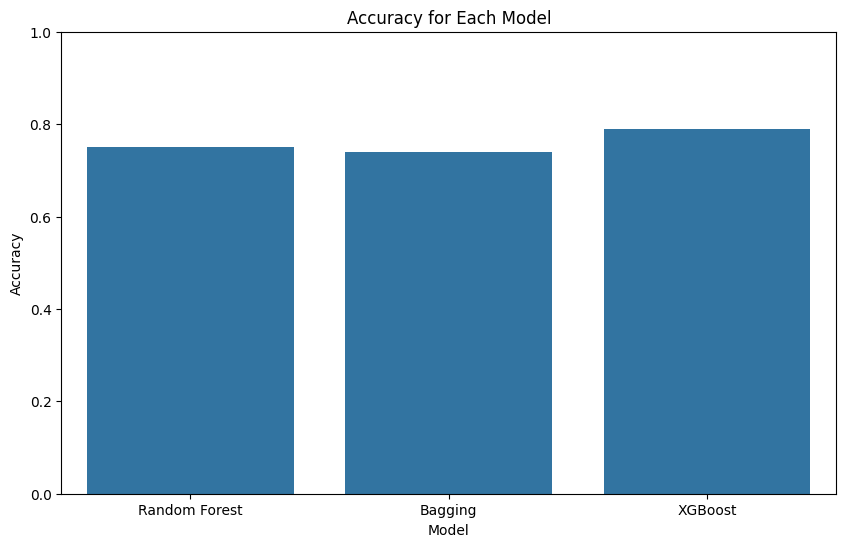

In [69]:
# Plotting the accuracies for each model
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=summary_classification_filtered_df)
plt.title('Accuracy for Each Model')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()


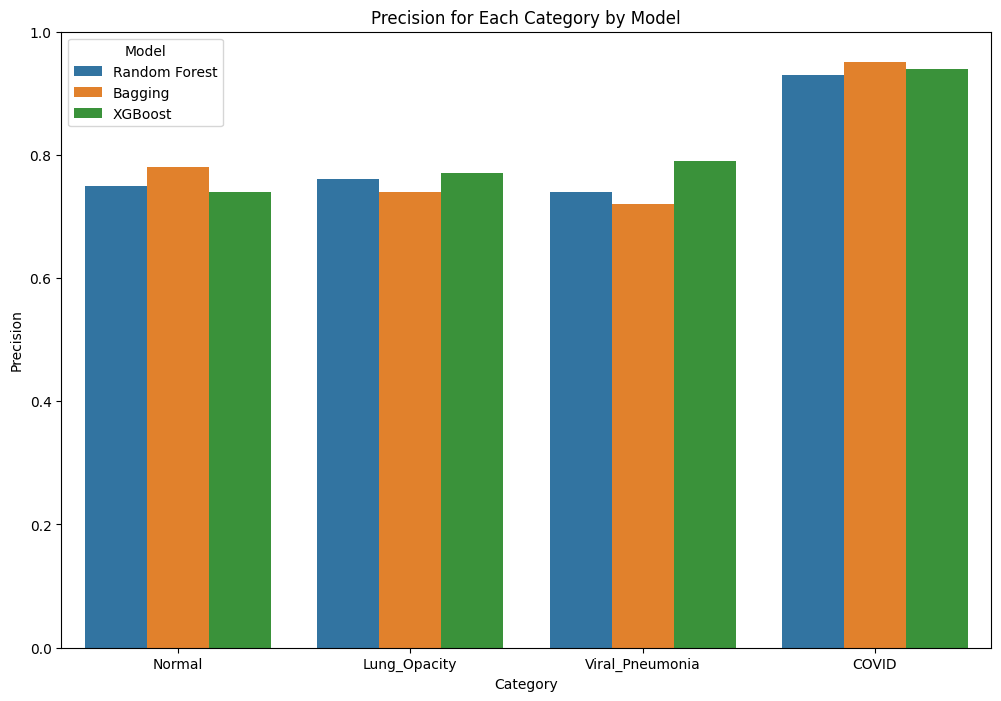

In [70]:
# Melting the DataFrame for precision values
precision_df = summary_classification_filtered_df.melt(id_vars=['Model'], 
                                                       value_vars=[f'Precision_{category}' for category in categories],
                                                       var_name='Metric', value_name='Value')

precision_df['Metric'] = precision_df['Metric'].str.replace('Precision_', '')

# Plotting Precision
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=precision_df)
plt.title('Precision for Each Category by Model')
plt.ylabel('Precision')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()

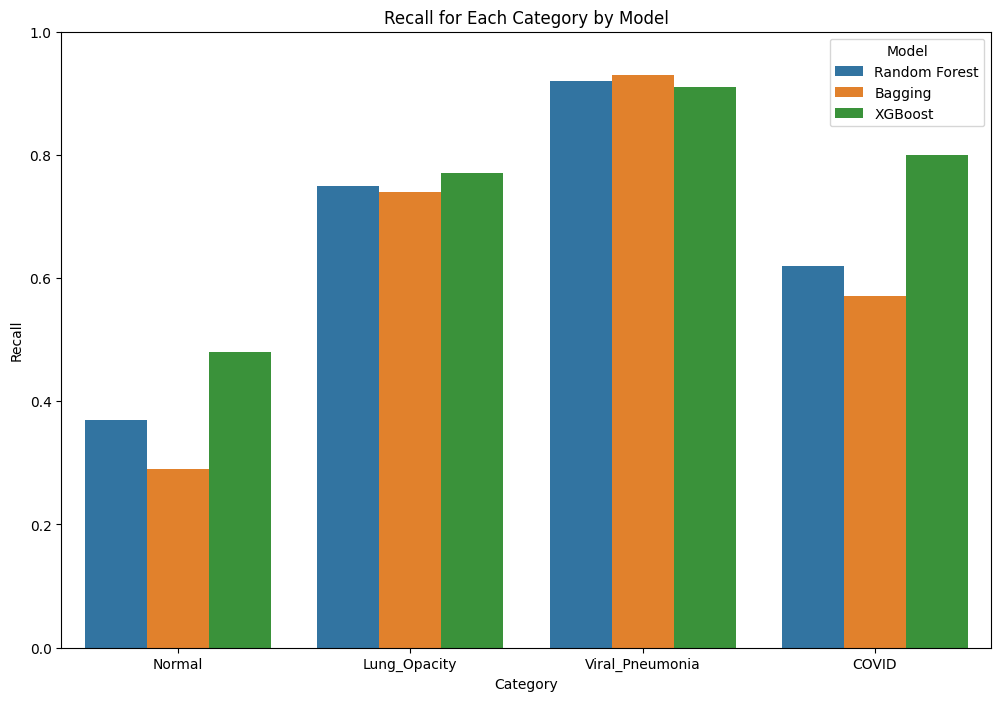

In [71]:
# Melting the DataFrame for recall values
recall_df = summary_classification_filtered_df.melt(id_vars=['Model'], 
                                                    value_vars=[f'Recall_{category}' for category in categories],
                                                    var_name='Metric', value_name='Value')

recall_df['Metric'] = recall_df['Metric'].str.replace('Recall_', '')

# Plotting Recall
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=recall_df)
plt.title('Recall for Each Category by Model')
plt.ylabel('Recall')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()

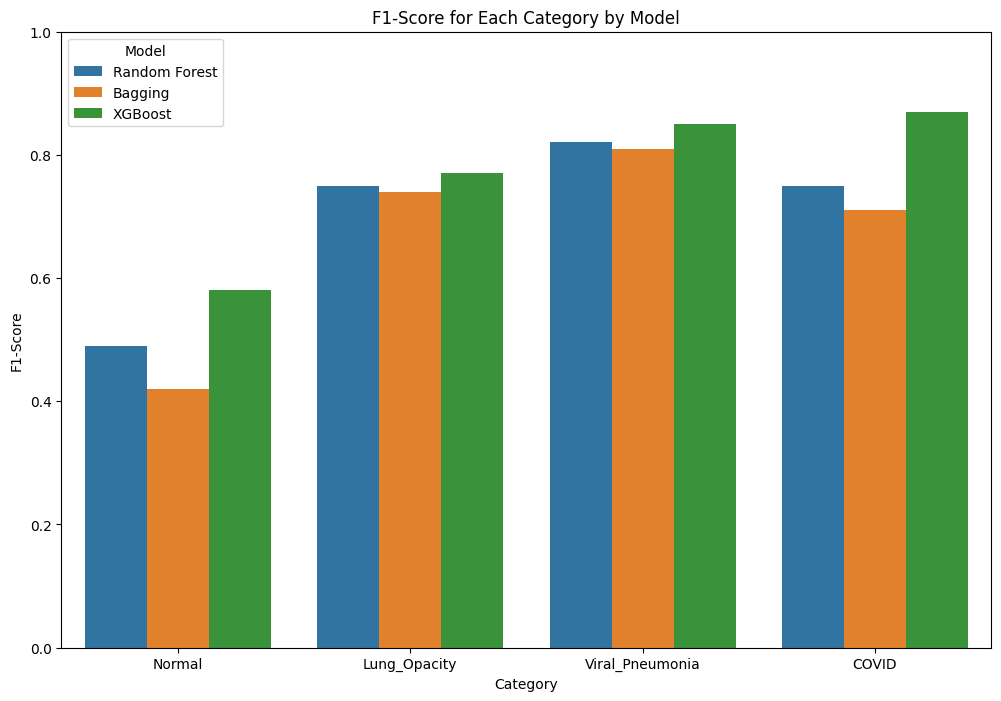

In [72]:
# Melting the DataFrame for F1-score values
f1_score_df = summary_classification_filtered_df.melt(id_vars=['Model'], 
                                                      value_vars=[f'F1-Score_{category}' for category in categories],
                                                      var_name='Metric', value_name='Value')

f1_score_df['Metric'] = f1_score_df['Metric'].str.replace('F1-Score_', '')

# Plotting F1-Score
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=f1_score_df)
plt.title('F1-Score for Each Category by Model')
plt.ylabel('F1-Score')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()

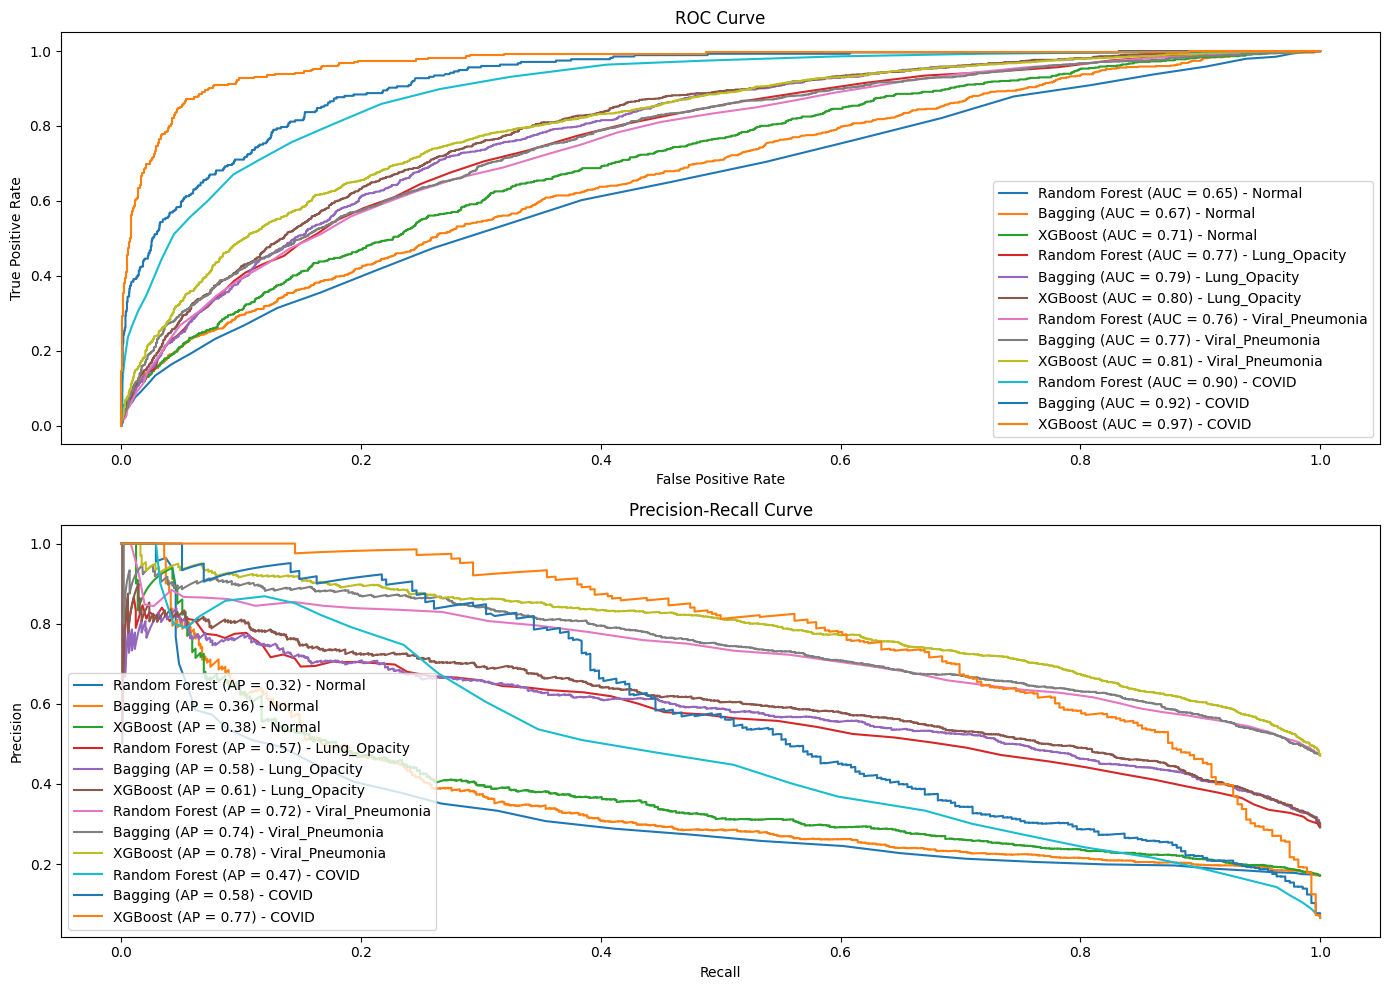

In [73]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities
rf_y_prob = rf_classifier_filtered.predict_proba(X_filtered_test_scaled)
bagging_y_prob = bagging_classifier_filtered.predict_proba(X_filtered_test_scaled)
xgb_y_prob = xgb_classifier_filtered.predict_proba(X_filtered_test_scaled)

# Initialize plots for ROC and PR curves
plt.figure(figsize=(14, 10))

# Calculate ROC and PR curves for each class
for i, category in enumerate(categories):
    # Random Forest
    rf_fpr, rf_tpr, _ = roc_curve(y_filtered_test_encoded == i, rf_y_prob[:, i])
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    rf_precision, rf_recall, _ = precision_recall_curve(y_filtered_test_encoded == i, rf_y_prob[:, i])
    rf_average_precision = average_precision_score(y_filtered_test_encoded == i, rf_y_prob[:, i])

    # Bagging Classifier
    bagging_fpr, bagging_tpr, _ = roc_curve(y_filtered_test_encoded == i, bagging_y_prob[:, i])
    bagging_roc_auc = auc(bagging_fpr, bagging_tpr)
    bagging_precision, bagging_recall, _ = precision_recall_curve(y_filtered_test_encoded == i, bagging_y_prob[:, i])
    bagging_average_precision = average_precision_score(y_filtered_test_encoded == i, bagging_y_prob[:, i])

    # XGBoost
    xgb_fpr, xgb_tpr, _ = roc_curve(y_filtered_test_encoded == i, xgb_y_prob[:, i])
    xgb_roc_auc = auc(xgb_fpr, xgb_tpr)
    xgb_precision, xgb_recall, _ = precision_recall_curve(y_filtered_test_encoded == i, xgb_y_prob[:, i])
    xgb_average_precision = average_precision_score(y_filtered_test_encoded == i, xgb_y_prob[:, i])

    # Plot ROC curve
    plt.subplot(2, 1, 1)
    plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f}) - {category}')
    plt.plot(bagging_fpr, bagging_tpr, label=f'Bagging (AUC = {bagging_roc_auc:.2f}) - {category}')
    plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.2f}) - {category}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')

    # Plot PR curve
    plt.subplot(2, 1, 2)
    plt.plot(rf_recall, rf_precision, label=f'Random Forest (AP = {rf_average_precision:.2f}) - {category}')
    plt.plot(bagging_recall, bagging_precision, label=f'Bagging (AP = {bagging_average_precision:.2f}) - {category}')
    plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AP = {xgb_average_precision:.2f}) - {category}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()



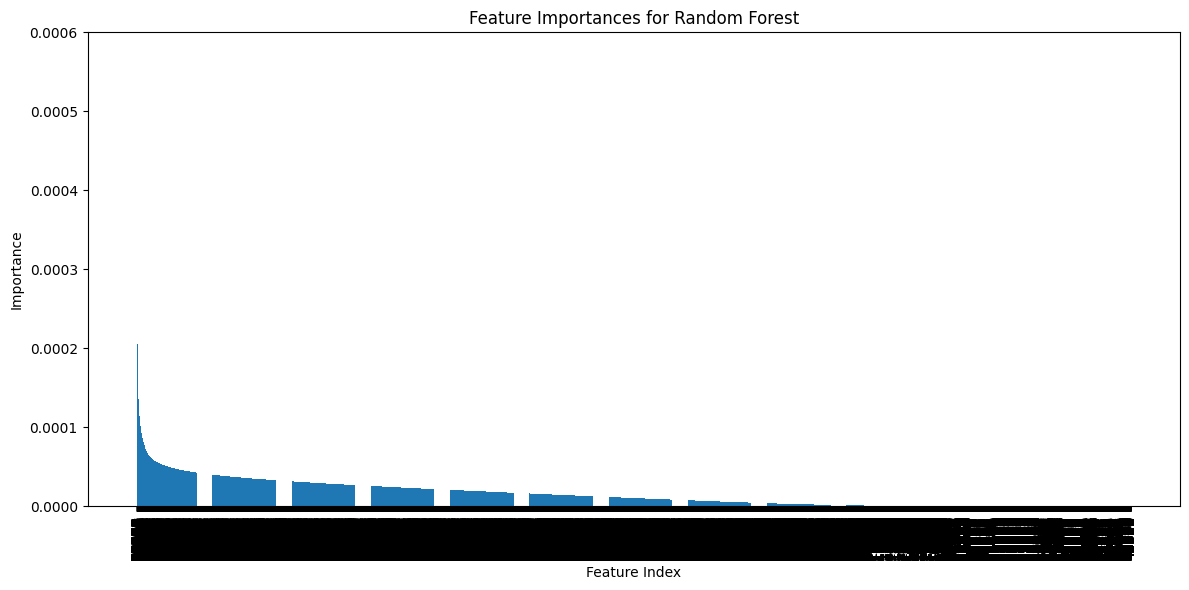

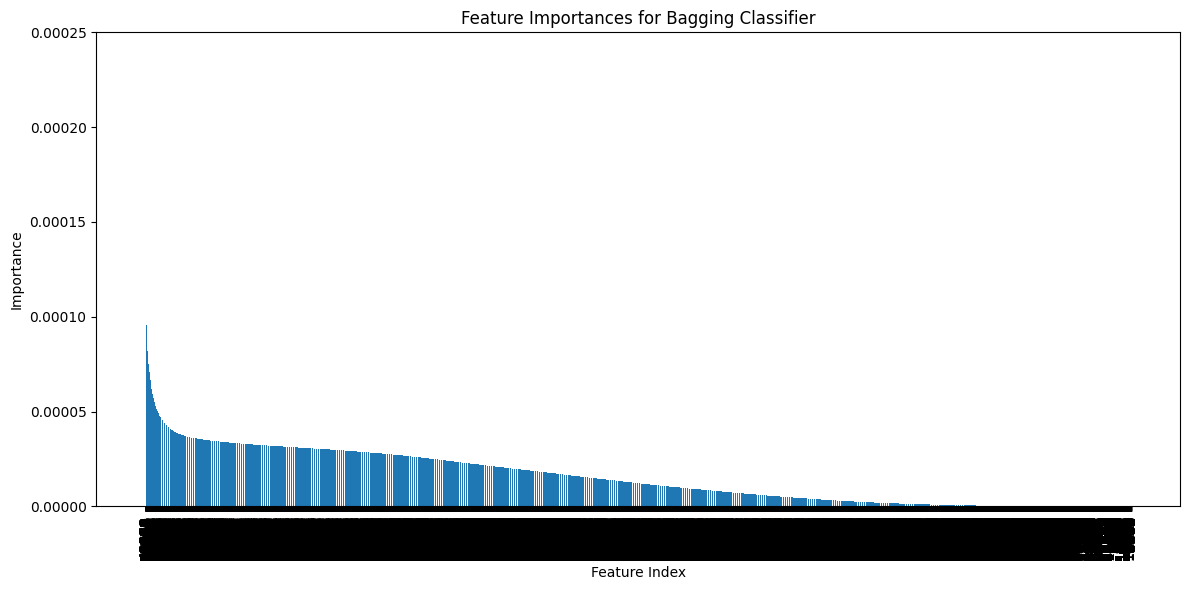

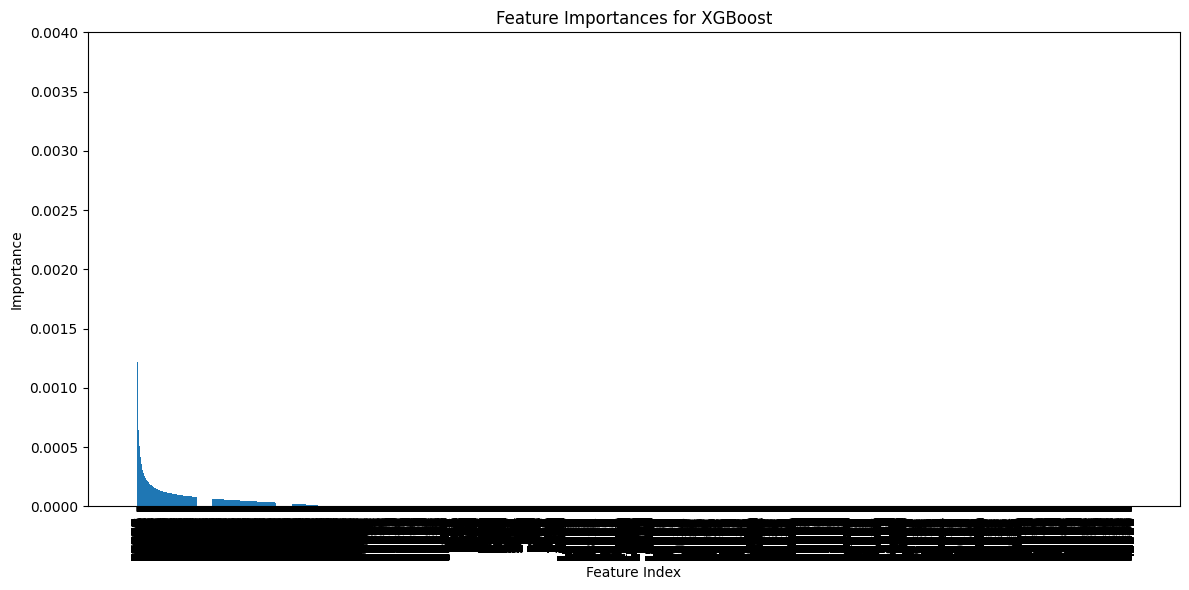

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

# predicted probabilities
rf_y_prob = rf_classifier_filtered.predict_proba(X_filtered_test_scaled)
bagging_y_prob = bagging_classifier_filtered.predict_proba(X_filtered_test_scaled)
xgb_y_prob = xgb_classifier_filtered.predict_proba(X_filtered_test_scaled)

# Feature Importances for Random Forest and Bagging Classifier
models = {
    'Random Forest': rf_classifier_filtered,
    'Bagging Classifier': bagging_classifier_filtered
}

for model_name, model in models.items():
    if model_name == 'Random Forest':
        importances = model.feature_importances_
        ylim = (0, 0.0006)
    elif model_name == 'Bagging Classifier':
        importances = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)
        ylim = (0, 0.00025)
    else:
        continue

    indices = np.argsort(importances)[::-1]
    features = X_filtered_train.columns  # Use the original DataFrame to get feature names

    plt.figure(figsize=(12, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(X_filtered_train.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_filtered_train.shape[1]), features[indices], rotation=90)
    plt.ylim(ylim)
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

# Feature Importances for XGBoost
xgb_importances = xgb_classifier_filtered.feature_importances_
indices = np.argsort(xgb_importances)[::-1]
features = X_filtered_train.columns  # Use the original DataFrame to get feature names

plt.figure(figsize=(12, 6))
plt.title('Feature Importances for XGBoost')
plt.bar(range(X_filtered_train.shape[1]), xgb_importances[indices], align='center')
plt.xticks(range(X_filtered_train.shape[1]), features[indices], rotation=90)
plt.ylim(0, 0.004)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
